In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

### Create network of communications

In [3]:
path = 'Sender-receiver-weight.csv'
sendReceiverdf = pd.read_csv(path)

In [4]:
sendReceiverdf

,Sender,Receiver,Weight
0,Richard Shapiro,Leslie Lawner,2
1,Richard Shapiro,Sandra McCubbin,2
2,Richard Shapiro,Jeff Dasovich,97
3,Richard Shapiro,Linda Robertson,7
4,Richard Shapiro,Paul Kaufman,7
...,...,...,...
4503,Benjamin Rogers,Randall Martin,4
4504,Benjamin Rogers,Michelle Kelso,2
4505,Kerri Thompson,Kate Symes,684
4506,Kerri Thompson,Carla Hoffman,15


In [5]:
import networkx as nx

G_comm = nx.DiGraph()


for idx, row in sendReceiverdf.iterrows():
    G_comm.add_edge(row['Sender'], row['Receiver'], weight=row['Weight'])

In [6]:
G_comm

### Create the network of similarity of communications

In [54]:
path = 'sender-text.csv'
senderTextdf = pd.read_csv(path)
senderTextdf['All texts'] = senderTextdf['All texts'].astype(str)

In [55]:
senderTextdf

,Unnamed: 0,Sender,All texts
0,0,Kerri Thompson,think price deal ; missing deal jeff richter s...
1,1,Chris Germany,nan; De Man change spelling Druckett Dracut ow...
2,2,Evelyn Metoyer,Hi Kate Mike Swerzbin ref Prebon counterparty ...
3,3,Gerald Nemec,Attached form; Attached form; Article relevant...
4,4,Tana Jones,connection execution new ISDA Master Agreement...
5,5,Mark E Haedicke,efficiently EWS Mark Forwarded Mark E Haedick...
6,6,James D Steffes,Jeff helpful feedback prior starting deal fun...
7,7,John J Lavorato,Original Message From Guerriero Michael mailto...
8,8,Richard B Sanders,kidding Columbus day found PUC Jeff DasovichEN...
9,9,Richard Shapiro,Leslieafter seeing point writing extremely r...


In [49]:
# text in sender
text_list = senderTextdf['All texts'].tolist()
sender_list = senderTextdf['Sender'].tolist()

In [12]:
# Calculate the similarity between the abstracts using n-grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3))
X = vectorizer.fit_transform(text_list)
similarity_matrix = cosine_similarity(X, X)

In [50]:
# Create a graph from the similarity matrix
# Draw an edge between papers with similarity in the fourth quartile

# Calculate the 75th percentile of the similarity matrix
import numpy as np
percentile_75 = np.percentile(similarity_matrix, 75)
print(f"75th percentile = {percentile_75}")

G_sim = nx.Graph()
for i in range(similarity_matrix.shape[0]):
    for j in range(i+1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > percentile_75:
            G_sim.add_edge(sender_list[i], sender_list[j])

75th percentile = 0.44058040025146533


In [13]:
# Save the graph to a CSV file
nx.write_edgelist(G_sim, 'similarity_graph_emailDataset.csv', delimiter=',')

In [14]:
# Not sure what this list is for. We need to use the sender_list, because it contains the nodes in both graphs
# unique_elements = list(set(sendReceiverdf['Sender'].tolist() + sendReceiverdf['Receiver'].tolist()))
# node_list = list(unique_elements)
# len(node_list)

### Calculate the intersection for every node

In [57]:
# Iterate over all nodes and find the neighbors of each node in G_comm and G_sim
intersection_dict = {}
for node in sender_list:
    # Check if node is in both graphs
    # TODO: Figure out why some nodes are not in both graphs
    if node not in G_comm.nodes or node not in G_sim.nodes:
        print(f"Node '{node}' is not in both graphs")
        continue
    network_comm_neighbors = set(G_comm.neighbors(node))
    network_sim_neighbors = set(G_sim.neighbors(node))
    intersection = network_comm_neighbors.intersection(network_sim_neighbors)
    union = network_comm_neighbors.union(network_sim_neighbors)
    jaccard_similarity = len(intersection) / len(union)
    intersection_dict[node] = {
        'intersection': intersection,
        'union': union,
        'jaccard_similarity': jaccard_similarity
    }

# # Save the intersection dictionary to a JSON file
# with open('./data/intersection_dict.json', 'w') as f:
#     json.dump(intersection_dict, f, indent=4)

Node 'Benjamin Rogers' is not in both graphs
Node 'Carol St Clair' is not in both graphs


In [53]:
intersection_dict

{'Kerri Thompson': {'intersection': {'Kate Symes'},
  'union': {'Carla Hoffman', 'Evelyn Metoyer', 'Kate Symes'},
  'jaccard_similarity': 0.3333333333333333},
 'Chris Germany': {'intersection': set(),
  'union': {'Airam Arteaga',
   'Alex Perkins',
   'Alfonso Trabulsi',
   'Alicia Perkins',
   'Alvin Thompson',
   'Amy Ochoa',
   'Andrea Ring',
   'Angel Fuller',
   'Angie Zeman',
   'Anne Bertino',
   'Audrey Cook',
   'Barbara N Gray',
   'Beverly Beaty',
   'Bhavna Pandya',
   'Brad McKay',
   'Brandon Oliveira',
   'Brenda H Fletcher',
   'Briant Baker',
   'Bryce Baxter',
   'Cecilia Olvera',
   'Chad Gronvold',
   'Chris Germany',
   'Chris Meyer',
   'Chris Ordway',
   'Christopher Spears',
   'Cindy Vachuska',
   'Clayton Vernon',
   'Colin Tonks',
   'Colleen Sullivan',
   'Cora Pendergrass',
   'Crystal Hyde',
   'Cynthia Franklin',
   'Dan J Hyvl',
   'Dan Junek',
   'Dana Daigle',
   'Daren J Farmer',
   'Darla Saucier',
   'Dave Scott',
   'David Oliver',
   'David Wile',

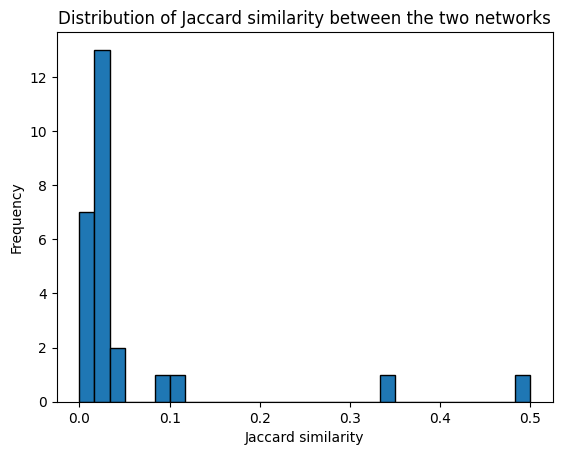

In [62]:
# Plot the distribution of the Jaccard similarity
jaccard_values = [value['jaccard_similarity'] for value in intersection_dict.values()]
fig, ax = plt.subplots()
ax.hist(jaccard_values, bins=30, edgecolor='black')
ax.set_xlabel('Jaccard similarity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Jaccard similarity between the two networks')
plt.show()

### Visualise networks

In [83]:
from matplotlib import patches
def visualise_sender_networks(selected_sender):

    # Get the neighbors of the selected sender in the two networks
    comm_neighbors = list(G_comm.neighbors(selected_sender))
    sim_neighbors = list(G_sim.neighbors(selected_sender))

    # Get the intersection
    intersection = set(comm_neighbors).intersection(set(sim_neighbors))
    only_comm = set(comm_neighbors).difference(set(sim_neighbors))
    only_sim = set(sim_neighbors).difference(set(comm_neighbors))

    G_vis = nx.Graph()
    for neighbor in only_comm:
        G_vis.add_edge(selected_sender, neighbor, network='communication')
    for neighbor in only_sim:
        G_vis.add_edge(selected_sender, neighbor, network='similarity')
    for neighbor in intersection:
        G_vis.add_edge(selected_sender, neighbor, network='both')

    # Visualise the graph
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G_vis)
    communication_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'communication']
    similarity_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'similarity']
    both_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'both']

    nx.draw_networkx_nodes(G_vis, pos, ax=ax, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G_vis, pos, edgelist=communication_edges, ax=ax, edge_color='red')
    nx.draw_networkx_edges(G_vis, pos, edgelist=similarity_edges, ax=ax, edge_color='blue')
    nx.draw_networkx_edges(G_vis, pos, edgelist=both_edges, ax=ax, edge_color='green')
    nx.draw_networkx_labels(G_vis, pos, ax=ax)

    ax.set_title(f'Neighbours of {selected_sender} in the two networks')

    # Add a legend for edges only
    communication_patch = patches.Patch(color='red', label='Communication')
    similarity_patch = patches.Patch(color='blue', label='Similarity')
    both_patch = patches.Patch(color='green', label='Both')
    ax.legend(handles=[communication_patch, similarity_patch, both_patch])

    ax.set_title(f'Neighbours of {selected_sender} in the two networks')
    
    plt.tight_layout()
    plt.show()

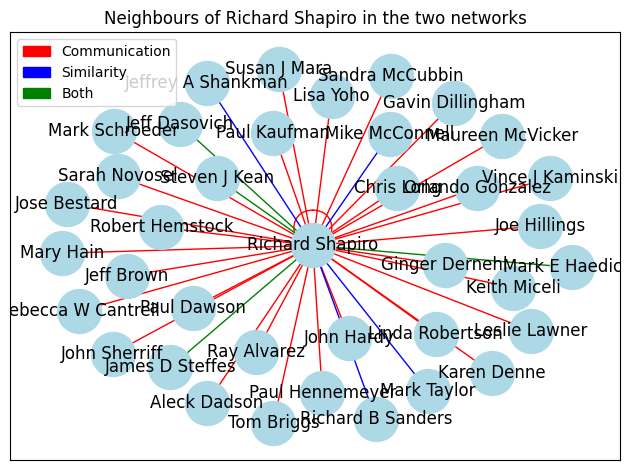

In [87]:
visualise_sender_networks('Richard Shapiro')